# SWaT Anomaly Detection with Enc-Dec

by dongmin kim (tommy.dm.kim@gmail.com)

In [1]:
import pandas as pd
import os
import pickle
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
import torch
from torch import nn
from torch.nn import functional as F
from torch.utils.data import DataLoader, Dataset
import numpy as np
import easydict

## Load data

In [2]:
from data.load_data import load_data

SWAT_TRAIN_PATH = './data/SWaT/SWaT_Dataset_Normal_v0.csv'
SWAT_TEST_PATH = './data/SWaT/SWaT_Dataset_Attack_v0.csv'
train_x, train_y = load_data(SWAT_TRAIN_PATH)
test_x, test_y = load_data(SWAT_TEST_PATH)

/home/nas3_userJ/dmkim/TSAD
     FIT101    LIT101  MV101  P101  P102    AIT201   AIT202   AIT203  \
0  2.470294  261.5804      2     2     1  244.3284  8.19008  306.101   
1  2.457163  261.1879      2     2     1  244.3284  8.19008  306.101   
2  2.439548  260.9131      2     2     1  244.3284  8.19008  306.101   
3  2.428338  260.2850      2     2     1  244.3284  8.19008  306.101   
4  2.424815  259.8925      2     2     1  244.4245  8.19008  306.101   

     FIT201  MV201  ...  P501  P502    PIT501  PIT502    PIT503    FIT601  \
0  2.471278      2  ...     1     1  10.02948     0.0  4.277749  0.000256   
1  2.468587      2  ...     1     1  10.02948     0.0  4.277749  0.000256   
2  2.467305      2  ...     1     1  10.02948     0.0  4.277749  0.000256   
3  2.466536      2  ...     1     1  10.02948     0.0  4.277749  0.000256   
4  2.466536      2  ...     1     1  10.02948     0.0  4.277749  0.000256   

   P601  P602  P603  Normal/Attack  
0     1     1     1         Normal  
1 

In [7]:
args = easydict.EasyDict({
    "batch_size": 128,
    "device": torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu'),
    "input_size": train_x.shape[1],
    "latent_size": 10,
    "output_size": train_x.shape[1],
    "window_size" : 100,
    "num_layers": 2,
    "learning_rate" : 0.001,
    "max_iter" : 100000,
    'early_stop' : True,
})

In [8]:
from data.dataset import SWaTDataset

train_dataset = SWaTDataset(train_x, train_y, window_size=args.window_size)
test_dataset = SWaTDataset(test_x, test_y, window_size=args.window_size)

train_loader = torch.utils.data.DataLoader(
                 dataset=train_dataset,
                 batch_size=args.batch_size,
                 shuffle=True)
test_loader = torch.utils.data.DataLoader(
                dataset=test_dataset,
                batch_size=args.batch_size,
                shuffle=False)

## Model

In [9]:
from LSTM_ENC_DEC_AD.model import LSTMAutoEncoder

model = LSTMAutoEncoder(
    input_dim=args.input_size,
    latent_dim=args.latent_size,
    window_size=args.window_size,
    num_layers=args.num_layers
)
model.to(args.device)

LSTMAutoEncoder(
  (encoder): Encoder(
    (lstm): LSTM(51, 10, num_layers=2, batch_first=True, dropout=0.1)
  )
  (reconstruct_decoder): Decoder(
    (lstm): LSTM(51, 10, num_layers=2, batch_first=True, dropout=0.1)
    (relu): ReLU()
    (fc): Linear(in_features=10, out_features=51, bias=True)
  )
)

## Loss function

In [10]:
def loss_function(x, pred_x):
    loss = F.mse_loss(x, pred_x)
    return loss

## Other settings

In [11]:
optimizer = torch.optim.Adam(model.parameters(), lr=args.learning_rate)

In [12]:
from utils.utils import EarlyStopping
BASE_PATH = "LSTM_ENC_DEC_AD"
MODEL_PATH = os.path.join(BASE_PATH, "checkpoints", "model.pt")
early_stopping = EarlyStopping(patience = 3, path = MODEL_PATH)

## Train

In [14]:
best_loss = None
epochs = tqdm(range(args.max_iter//len(train_loader)+1), leave=True)
for epoch in epochs:
    model.train()
    optimizer.zero_grad()
    train_iterator = tqdm(enumerate(train_loader), total=len(train_loader), desc="training", leave=True)

    train_loss = 0.0
    for i, batch_data in train_iterator:
        batch_data = batch_data[0].to(args.device)
        predict_values = model(batch_data)

        optimizer.zero_grad()
        loss = loss_function(batch_data, predict_values)
        loss.backward()
        optimizer.step()

        train_loss += loss.item()
        train_iterator.set_postfix({
            "train_loss": float(loss),
        })

    train_loss = train_loss / len(train_loader)
    epochs.set_postfix({
         "Train Loss": train_loss,
    })

    early_stopping(train_loss, model)
    if early_stopping.early_stop:
        print("Early stopping.")
        break

  0%|          | 0/26 [00:00<?, ?it/s]

training:   0%|          | 0/3881 [00:00<?, ?it/s]

training:   0%|          | 0/3881 [00:00<?, ?it/s]

training:   0%|          | 0/3881 [00:00<?, ?it/s]

training:   0%|          | 0/3881 [00:00<?, ?it/s]

training:   0%|          | 0/3881 [00:00<?, ?it/s]

training:   0%|          | 0/3881 [00:00<?, ?it/s]

EarlyStopping counter: 1 out of 3


training:   0%|          | 0/3881 [00:00<?, ?it/s]

training:   0%|          | 0/3881 [00:00<?, ?it/s]

training:   0%|          | 0/3881 [00:00<?, ?it/s]

training:   0%|          | 0/3881 [00:00<?, ?it/s]

training:   0%|          | 0/3881 [00:00<?, ?it/s]

training:   0%|          | 0/3881 [00:00<?, ?it/s]

training:   0%|          | 0/3881 [00:00<?, ?it/s]

training:   0%|          | 0/3881 [00:00<?, ?it/s]

EarlyStopping counter: 1 out of 3


training:   0%|          | 0/3881 [00:00<?, ?it/s]

training:   0%|          | 0/3881 [00:00<?, ?it/s]

training:   0%|          | 0/3881 [00:00<?, ?it/s]

training:   0%|          | 0/3881 [00:00<?, ?it/s]

training:   0%|          | 0/3881 [00:00<?, ?it/s]

EarlyStopping counter: 1 out of 3


training:   0%|          | 0/3881 [00:00<?, ?it/s]

training:   0%|          | 0/3881 [00:00<?, ?it/s]

EarlyStopping counter: 1 out of 3


training:   0%|          | 0/3881 [00:00<?, ?it/s]

training:   0%|          | 0/3881 [00:00<?, ?it/s]

training:   0%|          | 0/3881 [00:00<?, ?it/s]

EarlyStopping counter: 1 out of 3


training:   0%|          | 0/3881 [00:00<?, ?it/s]

training:   0%|          | 0/3881 [00:00<?, ?it/s]

EarlyStopping counter: 1 out of 3


In [13]:
model = LSTMAutoEncoder(
    input_dim=args.input_size,
    latent_dim=args.latent_size,
    window_size=args.window_size,
    num_layers=args.num_layers
)

model.load_state_dict(torch.load(MODEL_PATH))
model.to(args.device)

LSTMAutoEncoder(
  (encoder): Encoder(
    (lstm): LSTM(51, 10, num_layers=2, batch_first=True, dropout=0.1)
  )
  (reconstruct_decoder): Decoder(
    (lstm): LSTM(51, 10, num_layers=2, batch_first=True, dropout=0.1)
    (relu): ReLU()
    (fc): Linear(in_features=10, out_features=51, bias=True)
  )
)

## Calculate anomaly score

In [57]:
from LSTM_ENC_DEC_AD.anomaly_score import Anomaly_Calculator
from utils.utils import get_loss_list
from data.load_data import load_anomaly_intervals

train_loss_list = get_loss_list(args, model, train_loader, F.mse_loss)
test_loss_list = get_loss_list(args, model, test_loader, F.mse_loss)

anomaly_calculator = Anomaly_Calculator(train_loss_list)
anomaly_scores = anomaly_calculator.get_anomaly_score_list(test_loss_list)

x = list(range(len(anomaly_scores)))
y = anomaly_scores
intervals = load_anomaly_intervals(anomaly_labels = test_y, window_size = args.window_size)

Getting Loss List:   0%|          | 0/3881 [00:00<?, ?it/s]

loss list created: (496701, 51)


Getting Loss List:   0%|          | 0/3515 [00:00<?, ?it/s]

loss list created: (449820, 51)


  0%|          | 0/449820 [00:00<?, ?it/s]

=== Anomaly statistics ===
Total: 449820
mean[0.0001408060952747036], median[8.384239007300635e-05], min[3.0458351450837354e-05], max[0.0012509226516003997]


In [58]:
len(test_loss_list)

449820

In [59]:
intervals

[(1655, 2693),
 (2969, 3510),
 (4821, 5302),
 (6360, 6848),
 (7156, 7450),
 (7606, 8133),
 (11311, 12373),
 (15281, 16100),
 (73701, 74520),
 (90586, 90917),
 (92041, 92570),
 (93346, 93720),
 (102993, 103808),
 (115744, 116537),
 (116901, 117720),
 (132819, 133380),
 (142855, 143650),
 (172206, 172588),
 (172811, 173521),
 (198197, 199740),
 (227729, 263727),
 (279021, 279240),
 (279961, 281230),
 (302554, 303019),
 (347580, 348279),
 (361092, 361634),
 (371380, 371579),
 (371756, 372335),
 (389581, 390219),
 (436442, 437009),
 (437318, 437697),
 (438048, 438917),
 (443402, 445190)]

In [60]:
print(test_y)

[0 0 0 ... 0 0 0]


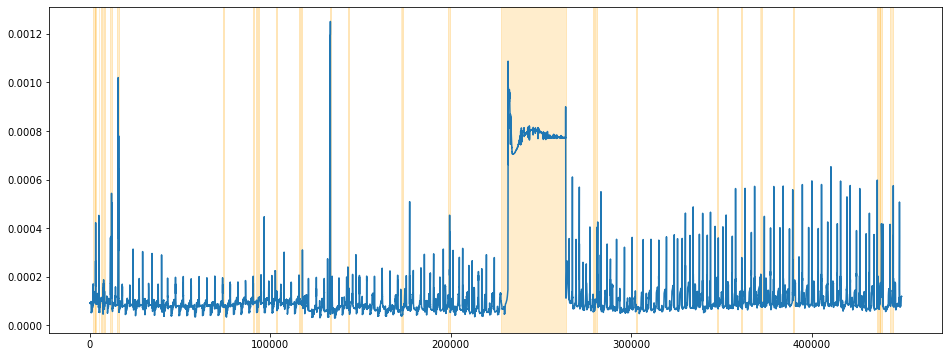

In [61]:
fig = plt.figure(figsize=(16, 6))
ax=fig.add_subplot()

ax.plot(x, y)
plt.rcParams['axes.facecolor']='white'
for s, e in intervals:
    ax.axvspan(s, e, alpha=0.2, color='orange')

### Finding Threshold

In [62]:
from sklearn.metrics import precision_score, recall_score, f1_score, confusion_matrix, classification_report
import seaborn as sns

In [63]:
len(anomaly_scores), anomaly_scores[0]

(449820, 9.055301996998787e-05)

In [64]:
anomaly_min, anomaly_max = np.min(anomaly_scores), np.max(anomaly_scores)
anomaly_min, anomaly_max

(3.0458351450837354e-05, 0.0012509226516003997)

In [65]:
test_y.shape

(449919,)

In [66]:
thresholds = np.linspace(anomaly_min, anomaly_max, 100)

In [67]:
len(anomaly_scores), len(test_y)

(449820, 449919)

In [68]:
precisions = []
recalls = []
f1s = []

for threshold in thresholds:
    anomaly_prediction = (anomaly_scores > threshold).astype(int)
    target_y = test_y[args.window_size-1:]

    p, r, f = precision_score(target_y, anomaly_prediction, zero_division = 1), recall_score(target_y, anomaly_prediction, zero_division = 1), f1_score(target_y, anomaly_prediction, zero_division = 1)
    precisions.append(p)
    recalls.append(r)
    f1s.append(f)

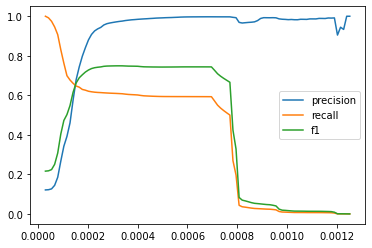

In [69]:
plt.plot(thresholds, precisions, label = "precision")
plt.plot(thresholds, recalls, label = "recall")
plt.plot(thresholds, f1s, label = "f1")
plt.legend()
plt.show()

In [70]:
threshold_idx = np.argmax(f1s)

In [71]:
best_threshold = thresholds[threshold_idx]

In [72]:
best_threshold

0.0003263284848204283

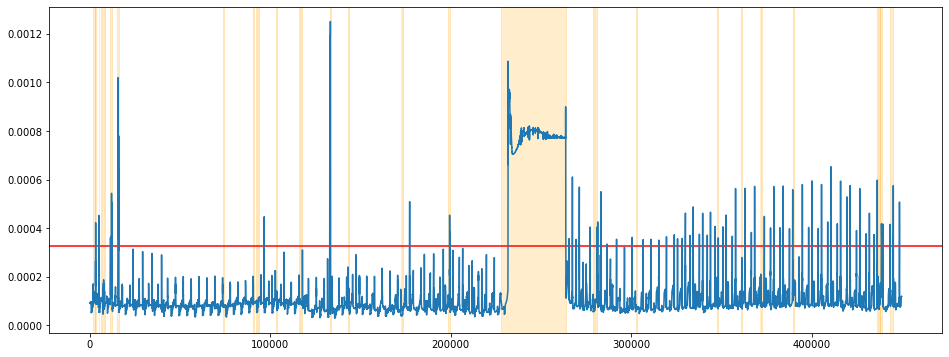

In [73]:
fig = plt.figure(figsize=(16, 6))
ax=fig.add_subplot()
ax.axhline(y = best_threshold, color = "r")
ax.plot(x, y)
plt.rcParams['axes.facecolor']='white'
for s, e in intervals:
    ax.axvspan(s, e, alpha=0.2, color='orange')

In [74]:
anomaly_prediction = (anomaly_scores > best_threshold).astype(int)
target_y = test_y[args.window_size-1:]

p, r, f = precision_score(target_y, anomaly_prediction), recall_score(target_y, anomaly_prediction),f1_score(target_y, anomaly_prediction)
p, r, f

(0.9737150559690558, 0.6087681371830573, 0.7491601848720549)

In [75]:
print(confusion_matrix(target_y, anomaly_prediction))

[[394339    897]
 [ 21355  33229]]


<AxesSubplot:>

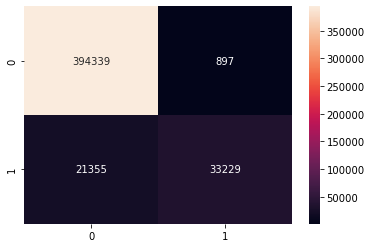

In [76]:
sns.heatmap(confusion_matrix(target_y, anomaly_prediction), annot = True, fmt = "d")